##Use Mean Average Precision (mAP) to evaluate performance

Algorithm to calculate mAP is from COCO 

Can be used to calculate the average score across a set of images or each image

In [33]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log
import coco_tools as coco_tools

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [34]:
import coco_tools as coco_tools
from collections import OrderedDict
import copy
import time
import numpy as np

from pycocotools import coco
from pycocotools import cocoeval
from pycocotools import mask

import tensorflow as tf

In [35]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) 

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [36]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(test_ids))
print(len(train_ids))

65
670


In [37]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [38]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
white = cate.loc[cate['foreground'] == 'white','filename'].tolist()
purple = cate.loc[cate['foreground'] == 'purple','filename'].tolist()
black = cate.loc[cate['foreground'] == 'black','filename'].tolist()
print("number of black image: %d" %len(black))
print("number of purple image: %d" %len(purple))
print("number of white image: %d" %len(white))

number of black image: 16
number of purple image: 120
number of white image: 599


In [39]:
train_index = [n for i, n in enumerate(train_ids) if n+".png" in white[:int(len(white)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) if n+".png" in white[int(len(white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[:int(len(purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[int(len(purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in black[:int(len(black)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in black[int(len(black)*0.8):]]

print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 534
length of validation set: 136
False


In [40]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

In [41]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0322.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0322.h5


In [43]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [51]:
def get_mAP(image_id, set):
    if set == "train":
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
        imagename = train_index[image_id]
    elif set == "val":
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
        imagename = val_index[image_id]
    #load gt_mask
    
    
    #load pd mask
    results = model.detect([original_image], verbose=1)
    r = results[0]

    bbox_pd = utils.extract_bboxes(r['masks'])
    classid_pd = r['class_ids']
    score_pd = r['scores']
    
    cate = [{'id':0, 'name':'background'}, {'id':1,'name':'nuclei'}]
    #dataset_train.load_mask(1)
    groundtruth_dict = coco_tools.ExportGroundtruthToCOCO(
         [1], [gt_bbox], [np.asarray(gt_class_id)],cate)
    bbox_pd = utils.extract_bboxes(r['masks'])
    detections_list = coco_tools.ExportDetectionsToCOCO(
      [1], [bbox_pd], [np.asarray(r['scores'])],
      [np.asarray(r['class_ids'])], cate, output_path=None)
    groundtruth = coco_tools.COCOWrapper(groundtruth_dict)
    detections = groundtruth.LoadAnnotations(detections_list)
    evaluator = coco_tools.COCOEvalWrapper(groundtruth, detections,
                                         agnostic_mode=False)
    metrics = evaluator.ComputeMetrics()
    mAP = [imagename, len(gt_class_id),metrics[0]['Precision/mAP'],\
           metrics[0]['Precision/mAP@.50IOU'],\
           metrics[0]['Precision/mAP@.75IOU']]
    
    
    return(mAP)

In [52]:
results = []
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    results.append(get_mAP(image_id, "val"))

Processing: e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  155.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   51.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...


INFO:tensorflow:DONE (t=0.00s)


creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.60s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

KeyboardInterrupt: 

In [141]:
mAPs = [i[2] for i in results]
print("mean mAP of test set: %f" %(sum(mAPs)/float(len(mAPs))))

mean mAP of test set: 0.385221


In [143]:
out = open("./result/mask_rcnn_shapes_0322_test_mAP.txt",'w')
out.write("\t".join(['image','NumofMask','Precision/mAP',
                     'Precision/mAP@.50IOU','Precision/mAP@.75IOU'])+"\n")

for i in results:
    out.write("\t".join(str(y) for y in i)+"\n")
out.close()

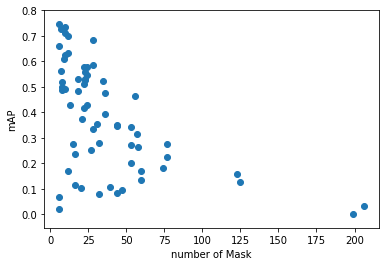

In [147]:
numMask = [i[1] for i in results]
plt.scatter(numMask,mAPs)
plt.xlabel("number of Mask")
plt.ylabel("mAP")
plt.show()

In [53]:
def display(imageName):
    
    if imageName in val_index:
        image = dataset_val.load_image(val_index.index(imageName))
    else: 
        image = dataset_train.load_image(train_index.index(imageName))
    
    
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

    

Processing 1 images
image                    shape: (603, 1272, 3)        min:    0.00000  max:  156.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   -4.90000
image_metas              shape: (1, 10)               min:    0.00000  max: 1272.00000


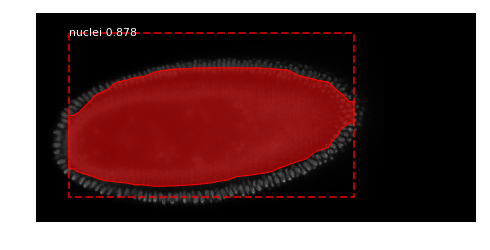

In [54]:
display('f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81')